![MADE](resources/made.jpg)

# Академия MADE


## Семинар 9: распознавание автомобильных номеров


Сегодня мы займемся задачей распознавания автомобильных номеров. Очевидно, она является частным случаем более широкой задачи - распознавания текста на изображениях.

Мы не будем затрагивать тему локализации номеров на изображении и сосредоточимся на "чтении" текста номерных знаков на уже подготовленных кропах.

#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`)
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты
6. Анализ проблем и что делать дальше

### 1. Общая схема

![box](resources/black_box.png)

Задачу распознавания текста на изображении можно рассматривать под разными углами:
- Как классификацию (1 слово = 1 класс);
- Как классификацию отдельных символов (то есть сначала разрезать на символы, затем каждый отдельно "прочитать");
- Как предсказание последовательностей (фиксированной или переменной длины).

Первый подход очевидно очень плох. Во-первых, при обучении мы будем иметь дело с очень разреженными данными (вероятно, для каких-то "классов"-слов у нас будет только по одному примеру), а в боевых данных могут оказаться слова, которых в обучающей выборке не было вовсе. Во-вторых, это классификация на гигантское число классов - такую модель будет очень непросто обучить. Однако, если в задаче сильно ограничен словарь (множество "слов"), то эту схему можно использовать (например, если вы хотите распознавать номера футболистов на форме).

Второй подход тоже не лишен недостатков. Самый очевидный - необходимо уметь хорошо разрезать слова на отдельные символы. В случае изображений из реальной жизни возникают дополнительные сложности в виде экзотических шрифтов, не позволяющих адекватно разделять соседние символы, шумов и т.д.

Третий подход не требует специальной подготовки данных и прост с точки зрения архитектуры. К нему мы и обратимся.

#### Convolutional Recurrent Neural Network (CRNN)

[paper](https://arxiv.org/abs/1507.05717)

![crnn](resources/crnn.png)

Модель CRNN (не путайте с R-CNN - семейством детекторов) предназначена для перевода изображений в текстовый вид. Она устроена следующим образом (см.изображение выше):
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении: ![receptive](resources/receptive.png)
2. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
3. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.

Быстрый FAQ:
* Q: Длина предсказанных последовательностей после первого шага фиксирована?
  
  A: Да, если используются батчи с изображениями одинакового размера.

* Q: Как из "двумерных" элементов после первого шага получаются "столбики" (как на картинке выше)?
  
  A: Можно сделать разворачивание в столбец (размер элементов станет -> `C * H`), пулинг по высоте (-> `C`), линейный слой, <ваш вариант>, ...

* Q: Длина предсказанных последовательностй после второго шага равна длине предсказанных в итоге слов?

  A: Нет, ее следует сделать больше. На последнем шаге используется `CTC-Loss`, который умеет "сжимать" предсказанные последовательности (в том числе с помощью `blank`-символов).
  
  
* Q: Как работает `CTC-Loss`?

  A: Пересмотрите лекцию, читайте [статью](https://www.cs.toronto.edu/~graves/icml_2006.pdf), смотрите [видео](https://www.youtube.com/watch?v=eYIL4TMAeRI), ...

### 2. Подготовка данных

In [103]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

Датасет представляет собой размеченные изображения автомобильных номеров РФ, собранных из интернета либо сгенерированных автоматически.
Формат данных = папка с изображениями + файл конфигурации, в котором в виде списка хранятся записи о тексте на каждом из изображений.

In [15]:
PATH_TO_DATA = "/data2/made/datasets/carocr-seminar/"  # Change to your path with unzipped data

In [13]:
config_path = os.path.join(PATH_TO_DATA, "config.json")
images_path = os.path.join(PATH_TO_DATA, "images")
assert os.path.isfile(config_path)
assert os.path.isdir(images_path)

with open(config_path, "rt") as fp:
    config = json.load(fp)

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["file"]),
                              "text": item["text"]})
config = config_full_paths

In [16]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 41141
First 3 items:
{'file': '/data2/made/datasets/carocr-seminar/images/ru_typenomer7_180509_o_11307847.jpg', 'text': '8090TB76'}
{'file': '/data2/made/datasets/carocr-seminar/images/ru_typenomer2_190509_o_12834692.jpg', 'text': 'BA428416'}
{'file': '/data2/made/datasets/carocr-seminar/images/ru_typenomer12_160328_o_8249929.jpg', 'text': 'AA509A25'}


Посмотрим на данные.

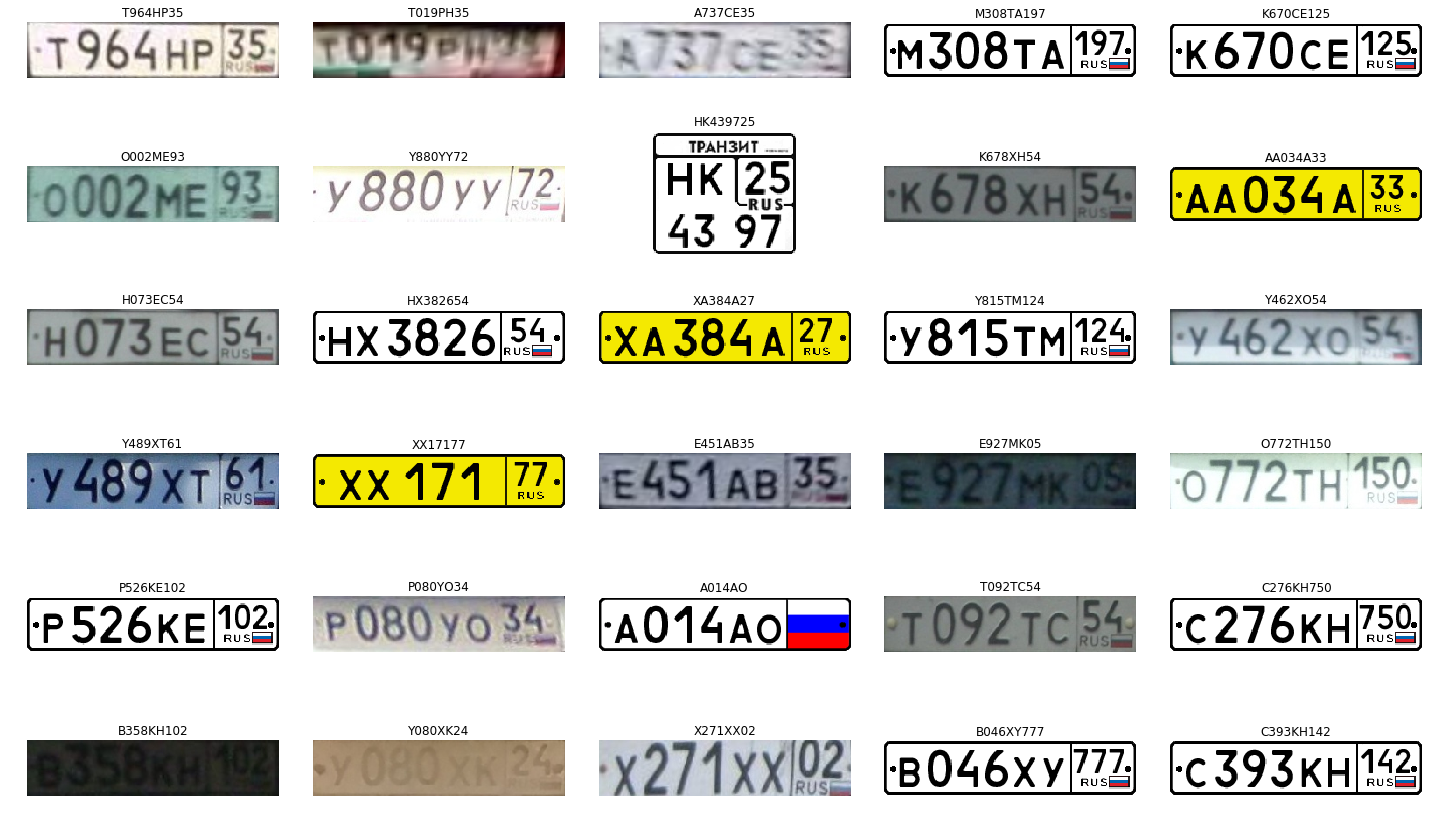

In [17]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Как видно, в данных встречаются номера разных типов. Для учебных целей отфильтруем примеры и оставим только те, которые относятся к "стандартным" гражданским номерным знакам, а именно имеющим вид `LDDDLLDD` или `LDDDLLDDD` (`L` = "letter", то есть буква, `D` = "digit", цифра).
Кроме того, отфильтруем примеры, в которые встречаются символы, не входящие в алфавит регистрационных знаков (см. переменную `abc` ниже).

**NB: используются только заглавные буквы латинского алфавита и цифры.**

In [18]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

In [19]:
print(ascii_uppercase)  # may be useful for functions below

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [20]:
print(digits)  # may be useful for functions below

0123456789


In [21]:
def compute_mask(text):
    """Compute letter-digit mask of text.
    Accepts string of text. 
    Returns string of the same length but with every letter replaced by 'L' and every digit replaced by 'D'.
    e.g. 'E506EC152' -> 'LDDDLLDDD'.
    Returns None if non-letter and non-digit character met in text.
    """
    # YOUR CODE HERE
    mask = []
    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None
    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99") == "LDDDLLDD"
assert compute_mask("P@@@KA@@") is None

In [22]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    Accepts string of text and string of alphabet. 
    Returns True if all chars in text are from alphabet and False else.
    """
    # YOUR CODE HERE
    for char in text:
        if char not in alphabet:
            return False
    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

In [23]:
def filter_data(config):
    """Filter config keeping only items with correct text.
    Accepts list of items.
    Returns new list.
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"],
                                    "text": item["text"]})
    return config_filtered

In [24]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

100%|██████████| 41141/41141 [00:00<00:00, 213999.77it/s]

Total items in data after filtering: 31345


Посмотрим, что осталось после фильтрации.

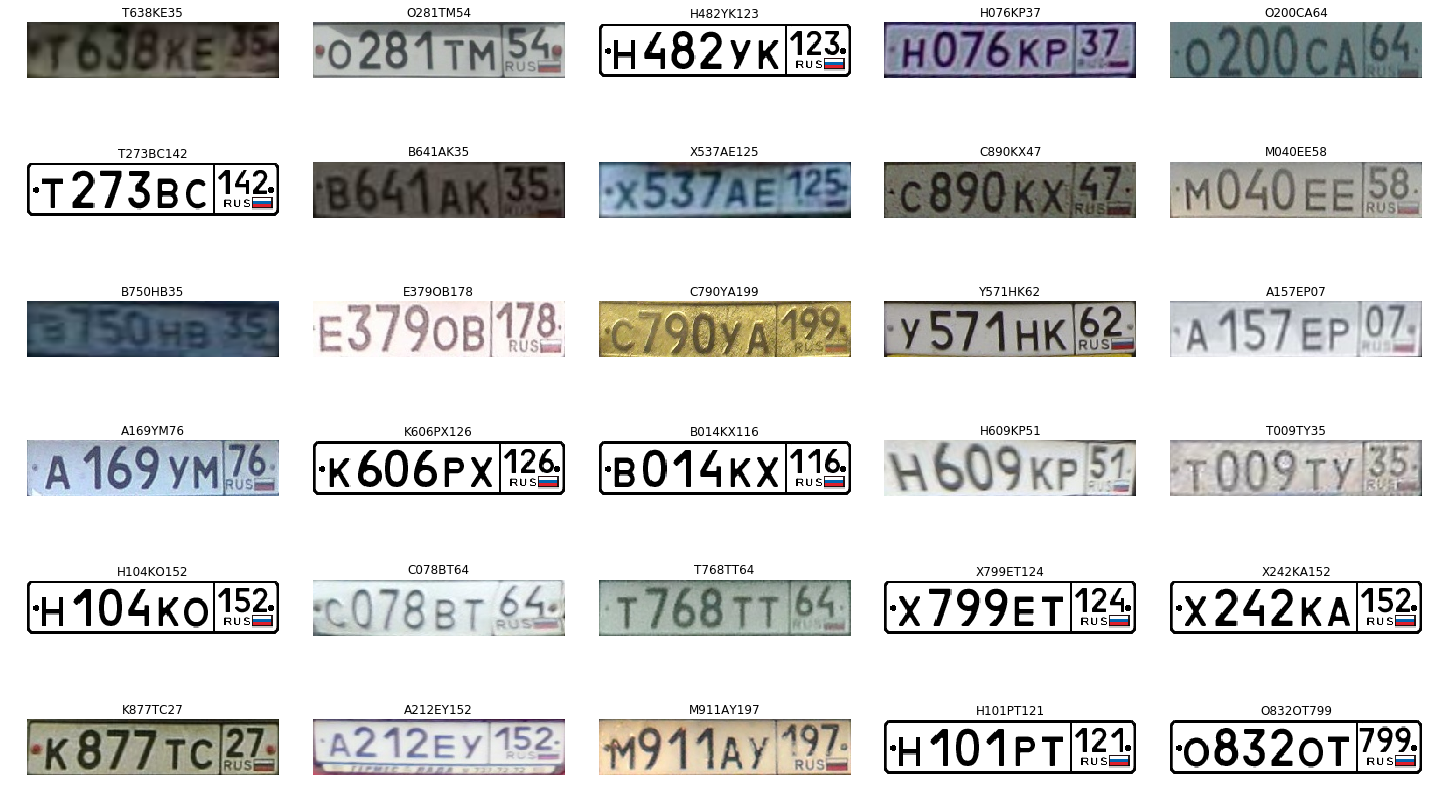

In [25]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера)
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).

In [26]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        Accepts:
        - config: list of items, each of which is a dict with keys "file" & "text".
        - alphabet: string of chars required for predicting.
        - transforms: transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = abc
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Return dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        Accepts string of text.
        Returns list of integers where each number is index of corresponding characted in alphabet + 1.
        """
        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 

**NB**: не забудьте про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).

In [27]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Accepts item with keys "image", "seq", "seq_len", "text".
        Returns item with image resized to self.size.
        """
        # YOUR CODE HERE
        item['image'] = cv2.resize(item['image'], self.size, interpolation=cv2.INTER_AREA)
        return item

Соберем датасет вместе:

In [28]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [29]:
x = dataset[0]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


Image shape: (64, 320, 3)
Seq: [12, 2, 1, 1, 20, 21, 9, 3] Seq_len: 8
Text: B100TY82


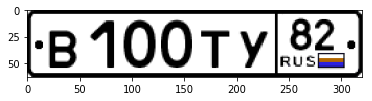

In [30]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`). Класс `DataLoader` плохо справляется (из коробки) с данными переменного размера, поэтому нам придется написать свою реализацию функции `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

In [31]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(torch.from_numpy(sample["image"]).permute(2, 0, 1).float())
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [32]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [33]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([32])
Seq: tensor([12,  2,  1,  1, 20, 21,  9,  3, 12, 10,  7,  5, 12, 13,  3,  2, 15,  8,
         6,  7, 13, 18,  8,  9, 15,  7,  6,  4, 14, 16,  8,  2],
       dtype=torch.int32)
Seq_len: tensor([8, 8, 8, 8], dtype=torch.int32)
Text: ['B100TY82', 'B964BE21', 'M756EP78', 'M653KH71']


### 3. Построение модели CRNN-like

Приступим к построению класса для модели нейросети.
Следуя описанию в начале этой страницы, вынесем (1) и (2) этапы пайплайна в отдельные компоненты модели (`self.cnn` и `self.rnn` соответсвенно).
Их можно реализовать практически независимо друг от друга, поэтому после занятия вы сможете самостоятельно поэкспериментировать со своими вариантами архитектур.

Начнем с построения `feature_extractor`. 

Для этого возьмем предобученную модель `ResNet18`, отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив только полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Иными словами, длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss`). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

**NB**: реализуйте метод `apply_projection`.

In [253]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        # YOUR CODE HERE
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [189]:
feature_extractor = FeatureExtractor()

In [190]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

**NB:** Для инициализации скрытого состояния `GRU` реализуйте метод `_init_hidden_()`. Про размерность `hidden_state` можно [посмотреть в документации](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU).

**NB:** `GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. Реализуйте приведение тензора из `FeatureExtractor` в этот вид в функции `_prepare_features_`.

In [294]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        # YOUR CODE HERE
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [260]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [261]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._prepare_features_(x).size() == (20, 1, 512)

In [262]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 23)

Теперь соберем две части в один класс CRNN.

In [263]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [264]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [271]:
crnn = CRNN()

In [272]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 23)

In [273]:
decode(y, abc)

['O4676346']

### 4. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

![ctc-01](resources/ctc_01.png)
![ctc-02](resources/ctc_02.png)

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 5. Обучение и результаты

Дальше никаких `#YOUR CODE HERE` не будет - если все необходимые функции выше реализованы, то можно запускать ячейки ниже и следить за обучением.

Можно выставить константу `ACTUALLY_TRAIN=False`, тогда вместо обучения будут загружены логи предварительно выполненного обучения.

In [352]:
ACTUALLY_TRAIN = False

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [295]:
crnn = CRNN()

Зададим гиперпараметры обучения:

In [296]:
num_epochs = 10
batch_size = 128
num_workers = 4

In [297]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [298]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [299]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [300]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

Запустим обучение (при параметрах по умолчанию ~30 минут):

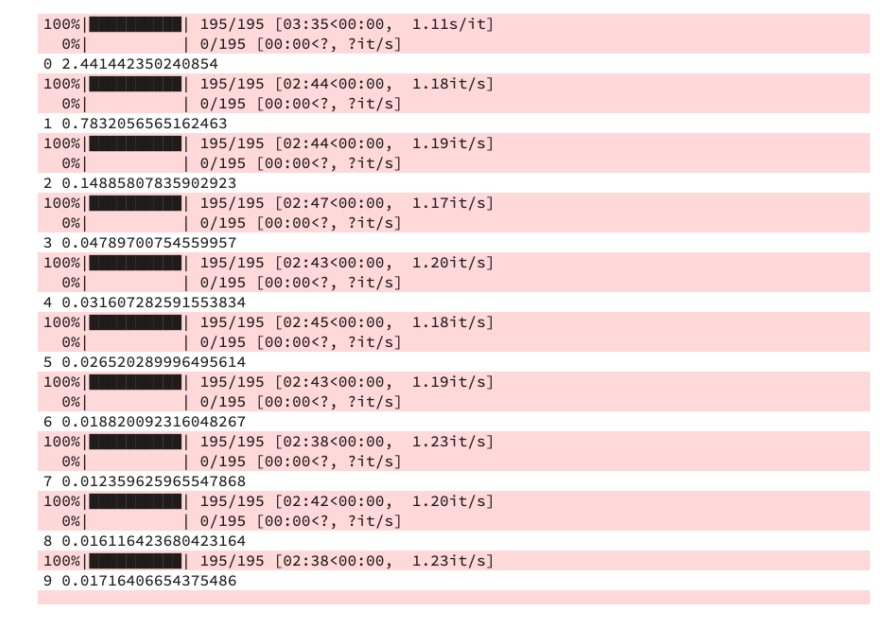

In [350]:
crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

Провалидируем:

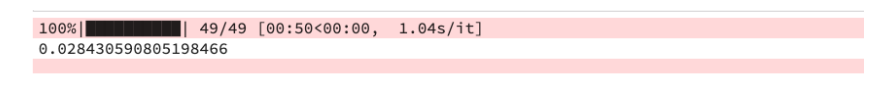

In [351]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())

    print(np.mean(val_losses))
else:
    image_val_log = cv2.imread("./resources/val_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

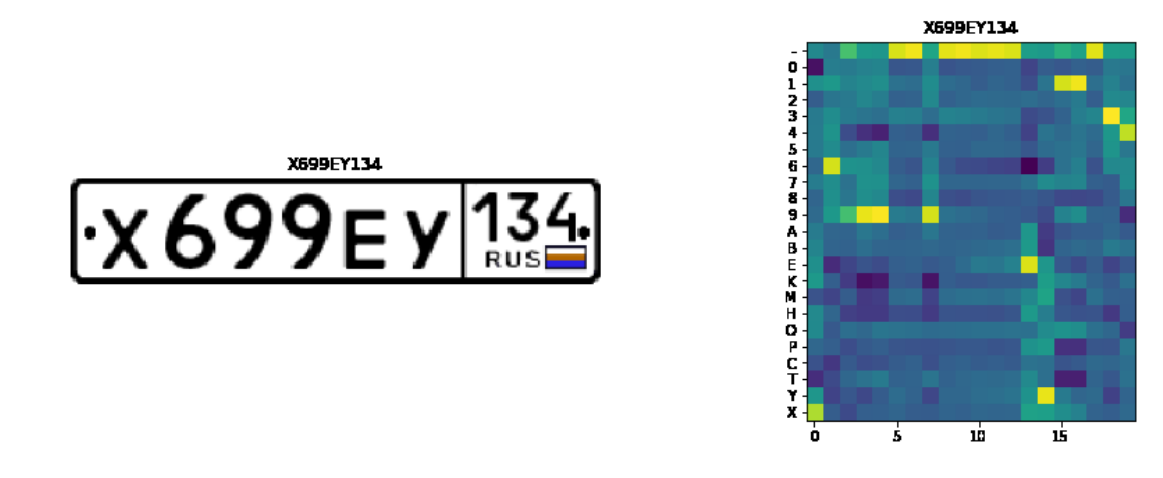

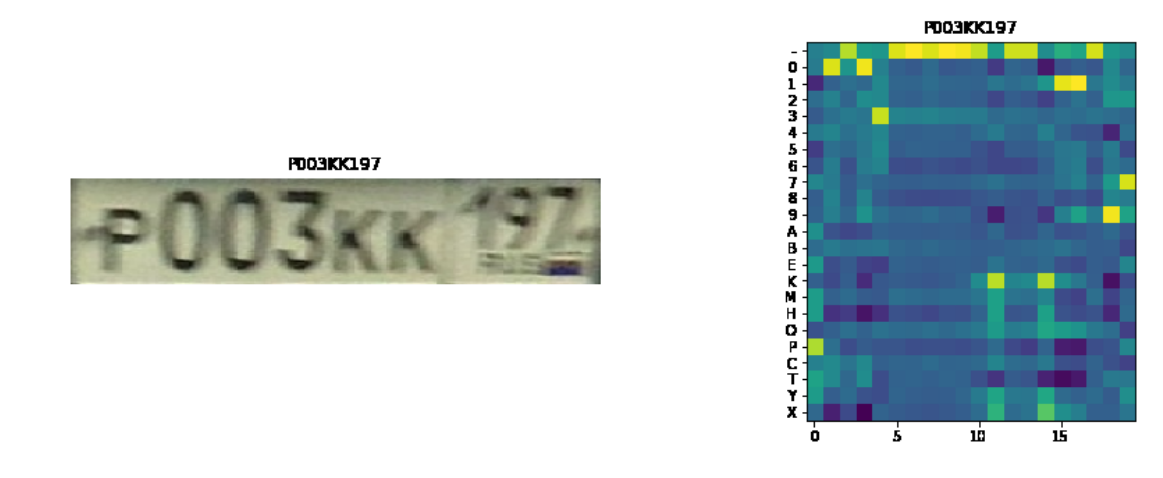

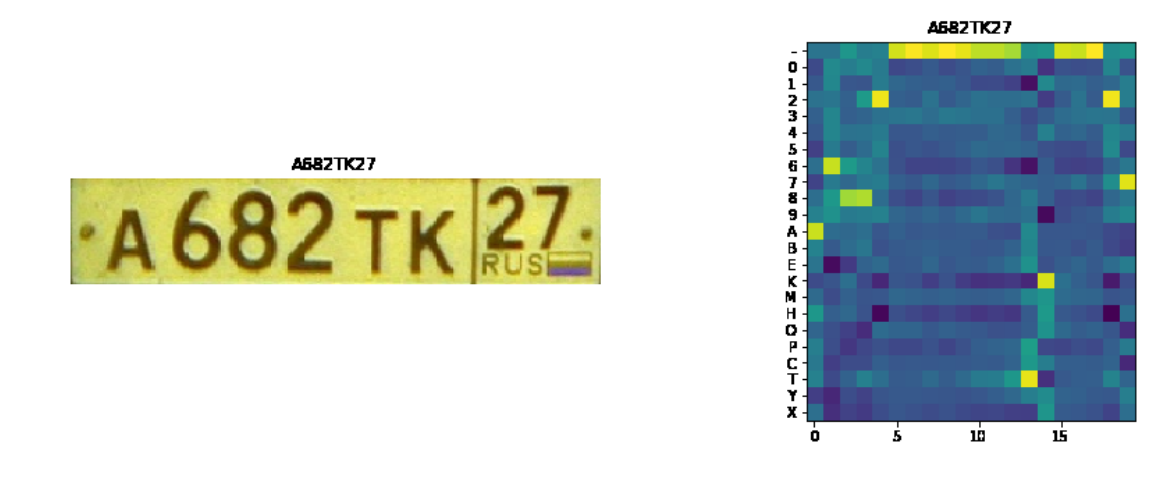

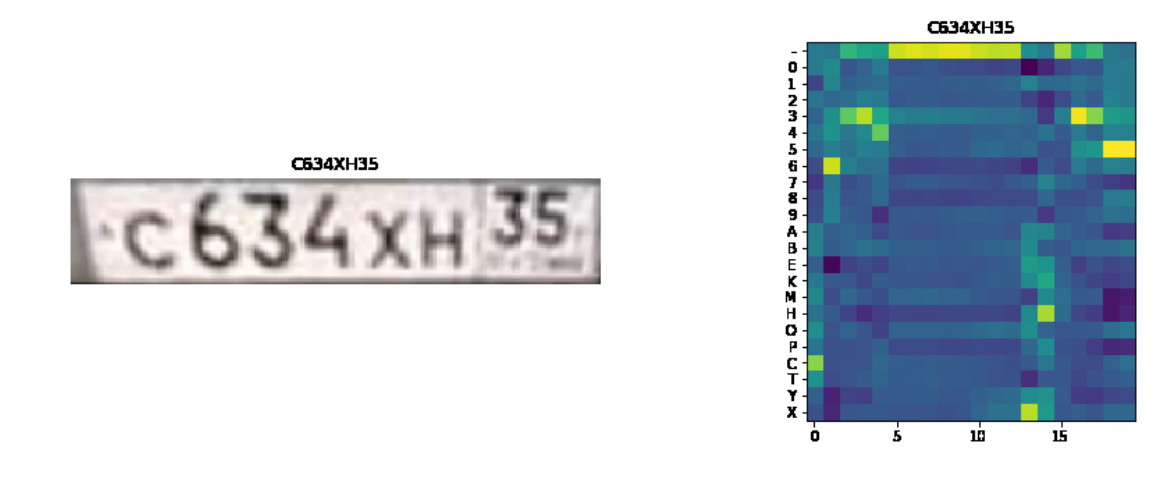

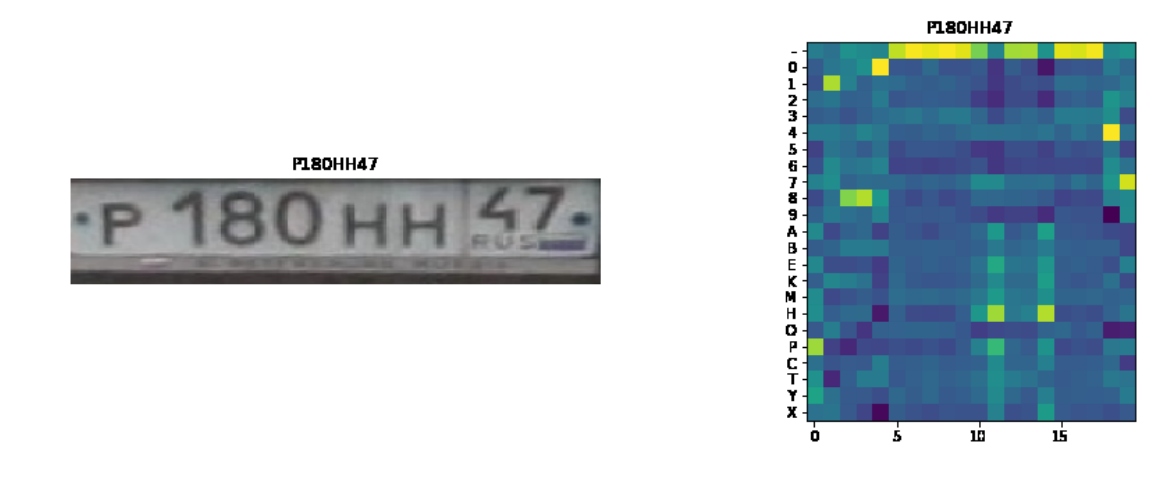

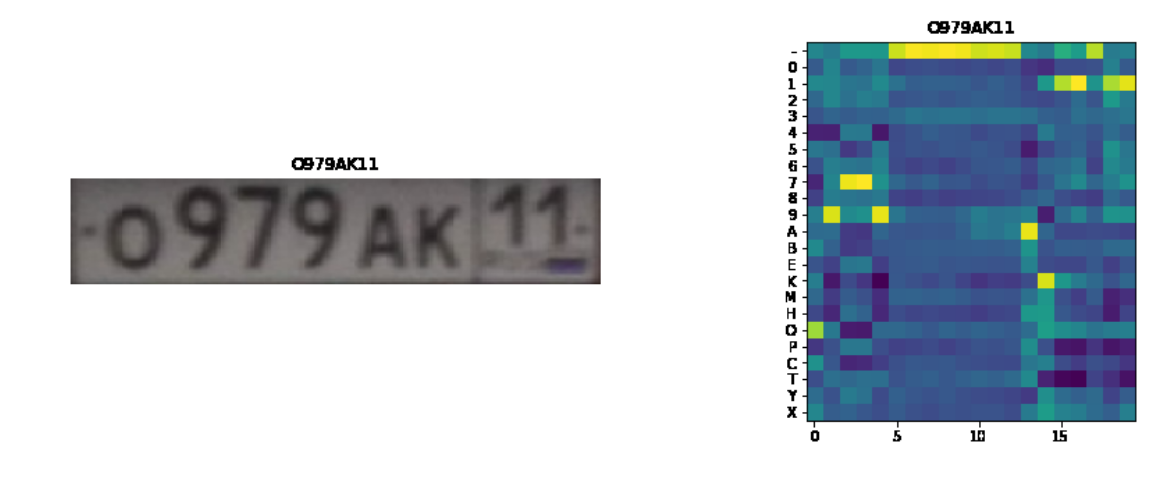

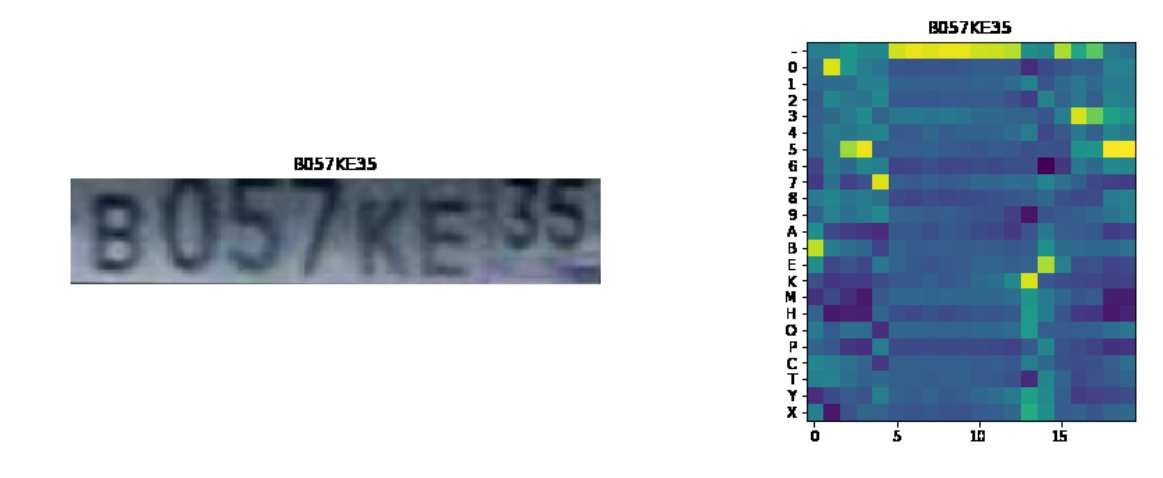

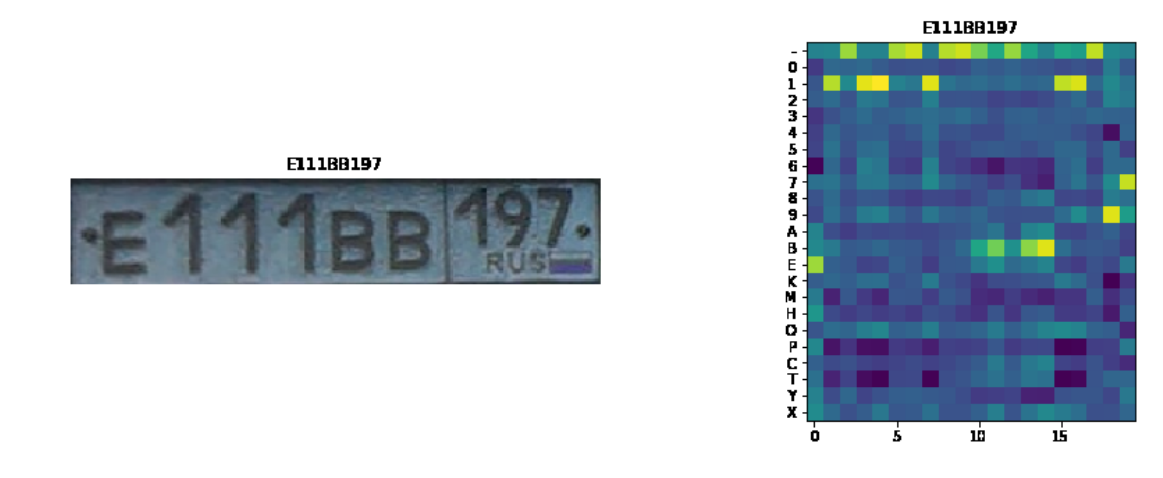

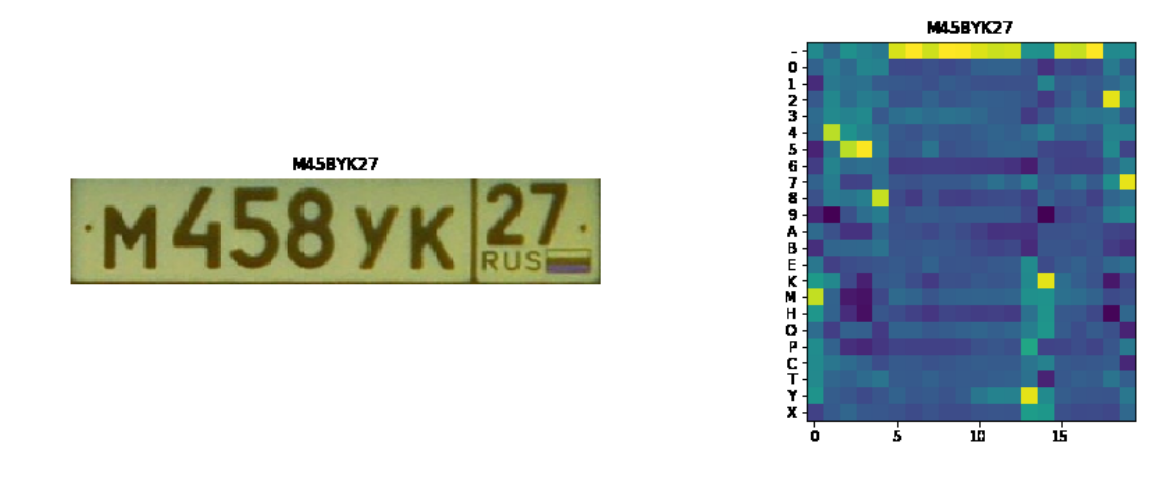

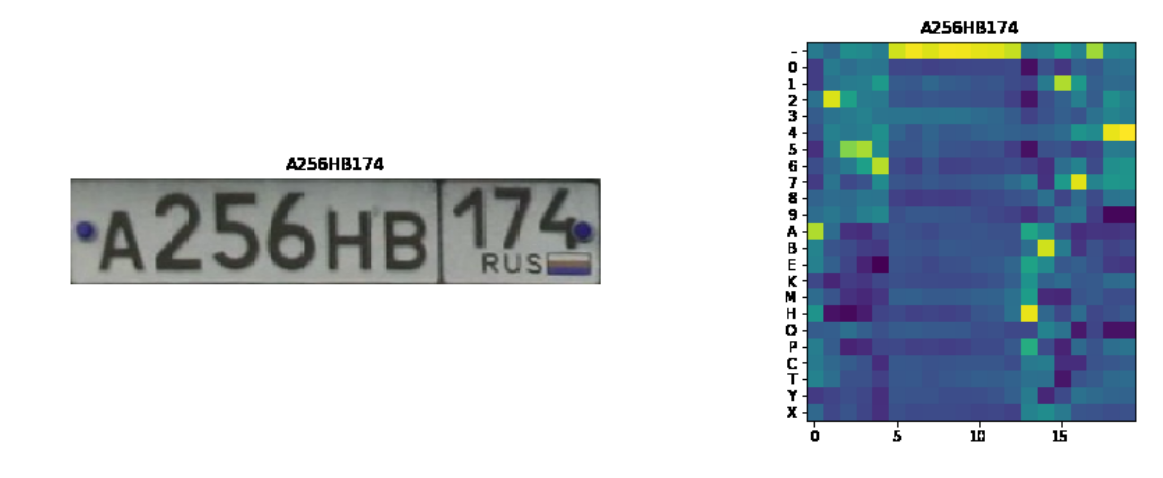

In [347]:
if ACTUALLY_TRAIN:
    
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]
    
    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T
        
        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts[i])
        
        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title(texts_pred[i])
        
        plt.show()
else:
    
    for i in range(1, 11):
        image_name = f"./resources/{str(i).zfill(2)}.png"
        image = cv2.imread(image_name)
        plt.figure(figsize=(20, 10))
        plt.imshow(image[:, :, ::-1], interpolation="bilinear")
        plt.axis("off")
        plt.show()

### 6. Что делать дальше?

- При обучении и валидации мы смотрели только на значение функции потерь. Обычно принято для оценки качества моделей использовать какую-либо репрезентативную метрику. Реализуйте подсчет `Accuracy` (доля верно предсказанных номеров) на обучающей и валидационной выборке.
- Как можно видеть по последним картинкам, наша модель почти ничего не предсказывает в середине последовательности (предсказывает `blank`). Попробуйте изменить архитктуру (или поиграйтесь с параметрами текущей) модели, чтобы более эффективно использовать ее.
- Проанализируйте, на каких примерах валидационной (и обучающей) выборки модель ошибается? Что можно сделать, чтобы полечить эти проблемы?
- Мы не умеем оценивать, насколько адекватны предсказания модели. Подумайте, как можно оценить "уверенность" модели в собственных предсказаниях?
- Вспомните, что мы оставили в выборке только "стандартные" номера. Попробуйте вернуть в обучение более сложные классы и обучить модель. Что получится?